# notebooks.qhdc_applications

## Setup

In [13]:
!git clone https://github.com/leonardoLavagna/qhdc

Cloning into 'qhdc'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 39 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 125.56 KiB | 4.65 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [14]:
import math
import os
os.chdir('qhdc')

In [15]:
!pip install -r requirements.txt

## Pattern completion

### QuAM-based Architecture

First we solve the simple pattern completion problem introduced in https://arxiv.org/abs/quant-ph/9807053.

In [16]:
from functions.patterns_utilities import *
from functions.QUAM import *
from qiskit.visualization import plot_histogram

In [17]:
patterns = generate_patterns(4,4)
patterns

['0010', '0111', '1111', '1001']

In [18]:
state, data = QuAM(patterns, search="110?")

0.50 |0010> + 0.50 |0111> + 0.50 |1001> + 0.50 |1111>


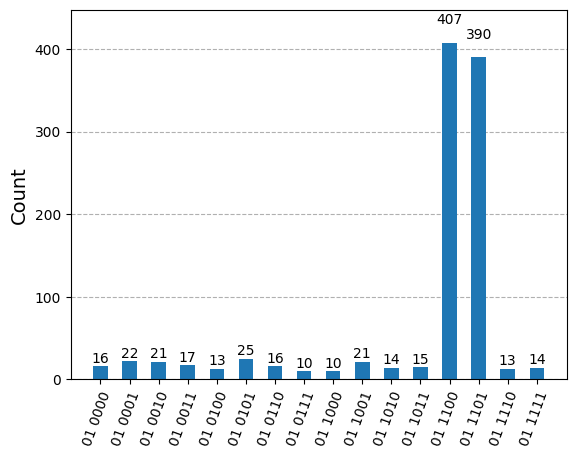

In [19]:
print(state)
plot_histogram(data)

Now we solve an associated similarity problem: given a string `search` not in the QuAM extract from the QuAM the most similar pattern. There are two options

**Option 1**
- Generate boolean expression `expression = similarity(patterns,search)`
- Build oracle `PhaseOracle(expression)`
- Grover search with given oracle

**Option 2**
- Encode state `|similarity(patterns, search)>`
- Run standard Grover to extended database `|patterns>, |similarity(patterns, search)>`

We will focus on Option 1, Option 2 is yet to be implemented.

In [20]:
search = "0101"

In [21]:
result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None, s=search, patterns=patterns, problem="similarity")
max(result.circuit_results[0], key=result.circuit_results[0].get)

'0111'

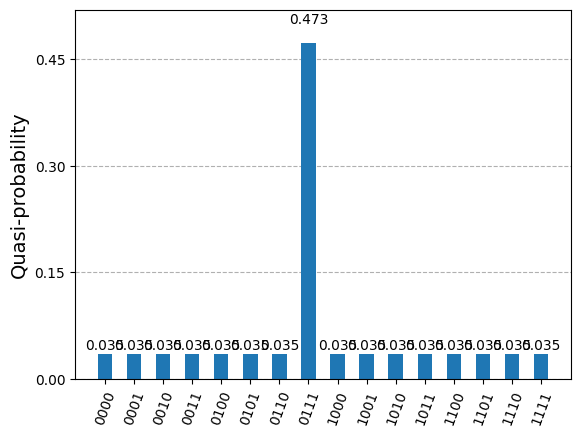

In [22]:
display(plot_histogram(result.circuit_results[0]))

### Circuit-based architecture

In [23]:
def encode_bitstring(bitstring: str, qr: QuantumRegister,
                     cr: ClassicalRegister, inverse=False) -> QuantumCircuit:
    """
    Create a quantum circuit for constructing the quantum superposition of the bitstring.

    Args:
        bitstring (str): Binary string to encode in the quantum circuit.
        qr (QuantumRegister): Quantum register to use for the circuit.
        cr (ClassicalRegister): Classical register to use for the circuit.
        inverse (bool): If True, creates the inverse of the encoding circuit.

    Returns:
        QuantumCircuit: Quantum circuit with the encoded bitstring.

    Raises:
        AssertionError: If the length of the bitstring is less than 2.
    """
    n = math.ceil(math.log2(len(bitstring))) + 1
    assert n > 2, "the length of bitstring must be at least 2"
    qc = QuantumCircuit(qr, cr)
    #the probability amplitude of the desired state
    #initialized to zero
    desired_vector = np.array([ 0.0 for i in range(2**n) ])
    amplitude = np.sqrt(1.0/2**(n-1))
    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1":
            pos += 1
        desired_vector[pos] = amplitude
    # Normalize the desired vector to ensure it has a norm of 1
    desired_vector = desired_vector / np.linalg.norm(desired_vector)
    if not inverse:
        qc.initialize(desired_vector, qr)
        qc.barrier(qr)
    else:
        # Create a copy of the initialization vector and cast it to real numbers
        desired_vector_real = np.real(desired_vector)
        qc.initialize(desired_vector_real,qr)
        for i in range(n):
            qc.measure(qr[i], cr[i])
    return qc

In [24]:
# Get corresponding quantum circuits (direct)
n = math.ceil(math.log2(len(patterns))) + 1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc_1 = encode_bitstring(patterns[0], qr, cr)
qc_2 = encode_bitstring(patterns[1], qr, cr)
qc_3 = encode_bitstring(patterns[2], qr, cr)
qc_4 = encode_bitstring(patterns[3], qr, cr)
circs = {patterns[0]: qc_1, patterns[1]: qc_2, patterns[2]: qc_3, patterns[3]: qc_4}

In [25]:
# Get corresponding quantum circuits (inverse)
inv_qc_1 = encode_bitstring(patterns[0], qr, cr, inverse=True)
inv_qc_2 = encode_bitstring(patterns[1], qr, cr, inverse=True)
inv_qc_3 = encode_bitstring(patterns[2], qr, cr, inverse=True)
inv_qc_4 = encode_bitstring(patterns[3], qr, cr, inverse=True)
inv_circs = {patterns[0]: inv_qc_1, patterns[1]: inv_qc_2, patterns[2]: inv_qc_3, patterns[3]: inv_qc_4}

In [26]:
shots = 1000
combined_circs = {}
count = {}
most_similar, most_similar_score = "", -1.0

for other_key in inv_circs:
    if other_key == search:
        continue
    combined_circs[other_key] = circs[other_key].compose(inv_circs[other_key])
    backend = Aer.get_backend("qasm_simulator")
    t_qc = transpile(combined_circs[other_key], backend=backend)
    job = backend.run(t_qc)
    st = job.result().get_counts(combined_circs[other_key])
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0

    print("Similarity score of",search,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score

print(search,"is most similar to", most_similar)

Similarity score of 0101 and 0010 is 0.246
Similarity score of 0101 and 0111 is 0.275
Similarity score of 0101 and 1111 is 0.0
Similarity score of 0101 and 1001 is 0.0
0101 is most similar to 0111


## Clustering task

### QuAM-based architecture

In [27]:
# TO BE IMPLEMENTED

## Circuit-based architecture

In [28]:
# TO BE IMPLEMENTED

## Classification task

We start with a bit-string similarity problem related to protozoan mithocondrial genetic codes extracted from https://www.bioinformatics.org/sms2/genetic_code.html.

### QuAM-based architecture

In [29]:
# TO BE IMPLEMENTED

### Circuit-based architecture

In [30]:
def compress(binary_string: str, k: int) -> str:
    """
    Compress a binary string to a fixed length k using SHA-256 hashing.

    Args:
        binary_string (str): The binary string to be compressed.
        k (int): The length of the compressed binary string.

    Returns:
        str: The compressed binary string of length k.

    Raises:
        AssertionError: If the length of the binary string is not a multiple of 8.
    """
    assert len(binary_string) % 8 == 0, "Binary string length must be a multiple of 8"
    # Convert binary string to bytes
    byte_length = len(binary_string) // 8
    byte_data = int(binary_string, 2).to_bytes(byte_length, byteorder='big')
    # Compute the SHA-256 hash of the byte data
    hash_object = hashlib.sha256(byte_data)
    hash_digest = hash_object.digest()
    # Convert hash digest to a binary string
    hash_binary_string = ''.join(format(byte, '08b') for byte in hash_digest)
    # Take the first k bits of the binary hash string
    compressed_binary_string = hash_binary_string[:k]
    return compressed_binary_string


def retrieve_original_from_compressed(compressed_string: str, lookup_table: Dict) -> str:
    """
    Retrieve the original binary string from the compressed string using a lookup table.

    Args:
        compressed_string (str): The compressed binary string.

    Returns:
        str: The original binary string, or None if not found.
    """
    return lookup_table.get(compressed_string, None)


def find_keys_by_value(d: Dict, target_value) -> List:
    """
    Find all keys in a dictionary that have a specific target value.

    Args:
        d (Dict): The dictionary to search.
        target_value: The value to search for.

    Returns:
        List: A list of keys that have the target value.
    """
    keys = [key for key, value in d.items() if value == target_value]
    return keys

In [31]:
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"
codes = {"YEAST": YEAST,"PROTOZOAN": PROTOZOAN,"BACTERIAL":BACTERIAL}

### QuAM-based Architecture

In [32]:
# Preprocessing
YEAST_bin = list(YEAST)
PROTOZOAN_bin = list(PROTOZOAN)
BACTERIAL_bin = list(BACTERIAL)
for i in range(len(YEAST_bin)):
    if YEAST_bin[i] == "-":
        YEAST_bin[i] = 0
    if YEAST_bin[i] == "M":
        YEAST_bin[i] = 1
for i in range(len(PROTOZOAN_bin)):
    if PROTOZOAN_bin[i] == "-":
        PROTOZOAN_bin[i] = 0
    if PROTOZOAN_bin[i] == "M":
        PROTOZOAN_bin[i] = 1
for i in range(len(BACTERIAL_bin)):
    if BACTERIAL_bin[i] == "-":
        BACTERIAL_bin[i] = 0
    if BACTERIAL_bin[i] == "M":
        BACTERIAL_bin[i] = 1

In [33]:
patterns = [''.join(str(bit) for bit in YEAST_bin), ''.join(str(bit) for bit in BACTERIAL_bin)]
search = [''.join(str(bit) for bit in PROTOZOAN_bin)]
search = search[0]
search

'0011000000000000000100000000000011110000000000000001000000000000'

**Remark 2 .** If you try the following
```
result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None, s=search, patterns=patterns, problem="similarity")
max(result.circuit_results[0], key=result.circuit_results[0].get)
```
you will get an error:
```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-182-82261044df0e> in <cell line: 1>()
----> 1 result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None, s=search, patterns=patterns, problem="similarity")
      2 max(result.circuit_results[0], key=result.circuit_results[0].get)

1 frames
/usr/local/lib/python3.10/dist-packages/qiskit/quantum_info/states/statevector.py in from_label(cls, label)
    698         # Initialize Z eigenstate vector
    699         num_qubits = len(label)
--> 700         data = np.zeros(1 << num_qubits, dtype=complex)
    701         pos = int(z_label, 2)
    702         data[pos] = 1

ValueError: Maximum allowed dimension exceeded
```
hashing is needed...

In [34]:
k = 8
patterns_comp = []
for pattern in patterns:
    pattern = compress(pattern,k)
    patterns_comp.append(pattern)
search_comp = compress(search,k)
print(patterns_comp, search_comp)

lookup_table = {}
for original_string in patterns:
    compressed_string = compress(original_string,k)
    lookup_table[compressed_string] = original_string
lookup_table

['10011000', '01001110'] 10110001


{'10011000': '0000000000000000000000000000000000110000000000000000000000000000',
 '01001110': '0001000000000000000100000000000011110000000000000001000000000000'}

Now we can apply Grover...

In [35]:
import operator

result = grover_search(qc=None, x=None, c=None, output=None, xc=None, cc=None, R=None, s=search_comp, patterns=patterns_comp, problem="similarity")
sorted_results = dict(sorted(result.circuit_results[0].items(), key=operator.itemgetter(1), reverse=True))


In [36]:
recovered_answers = []
for i in range(len(list(sorted_results.keys()))):
  if retrieve_original_from_compressed(list(sorted_results.keys())[i],lookup_table) is not None:
    recovered_answers.append(retrieve_original_from_compressed(list(sorted_results.keys())[i],lookup_table))

In [37]:
original_string = retrieve_original_from_compressed(max(result.circuit_results[0], key=result.circuit_results[0].get),lookup_table)
answer = [0]*len(original_string)
for i in range(len(original_string)):
    if original_string[i] == "0":
        answer[i] = "-"
    if original_string[i] == "1":
        answer[i] = "M"
answer = ''.join(answer)
key = find_keys_by_value(codes, answer)
item = max(result.circuit_results[0], key=result.circuit_results[0].get)
print(f'YEAST is most similar to {key[0]} with similarity {sorted_results[item]}')

YEAST is most similar to YEAST with similarity 0.0347909927368156


In [38]:
other_string = recovered_answers[1]
other_answer = [0]*len(other_string)
for i in range(len(other_string)):
    if other_string[i] == "0":
        other_answer[i] = "-"
    if other_string[i] == "1":
        other_answer[i] = "M"
other_answer = ''.join(other_answer)
key = find_keys_by_value(codes, other_answer)
item = find_keys_by_value(lookup_table, other_string)[0]
print(f'YEAST is also similar to {key[0]} with similarity {sorted_results[item]}')

YEAST is also similar to BACTERIAL with similarity 0.0037851333618163


### Circuit-based architecture

In [39]:
# Get corresponding quantum circuits (direct)
n = math.ceil(math.log2(len(YEAST))) + 1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
qc_yeast = encode_bitstring(YEAST, qr, cr)
qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr)
qc_bacterial = encode_bitstring(BACTERIAL, qr, cr)
circs = {"YEAST": qc_yeast, "PROTOZOAN": qc_protozoan, "BACTERIAL": qc_bacterial}
#qc_yeast.draw()

In [40]:
# Get corresponding quantum circuits (inverse)
inverse_qc_yeast = encode_bitstring(YEAST,qr,cr, inverse=True)
inverse_qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr, inverse=True)
inverse_qc_bacterial = encode_bitstring(BACTERIAL, qr, cr, inverse=True)
inverse_circs = {"YEAST": inverse_qc_yeast, "PROTOZOAN": inverse_qc_protozoan, "BACTERIAL": inverse_qc_bacterial}

In [41]:
key = "PROTOZOAN"
shots = 1000

combined_circs = {}
count = {}

most_similar, most_similar_score = "", -1.0

for other_key in inverse_circs:
    if other_key == key:
        continue
    combined_circs[other_key] = circs[key].compose(inverse_circs[other_key])
    backend = Aer.get_backend("qasm_simulator")
    t_qc = transpile(combined_circs[other_key], backend=backend)
    job = backend.run(t_qc)
    st = job.result().get_counts(combined_circs[other_key])
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0

    print("Similarity score of",key,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score

print(key,"is most similar to", most_similar)

Similarity score of PROTOZOAN and YEAST is 0.008
Similarity score of PROTOZOAN and BACTERIAL is 0.022
PROTOZOAN is most similar to BACTERIAL
